# Lab Assignment Six: CNNs
### Authors
- Juliana Antonio
- Xiaona Hang
- Chuanqi Deng
### 1. Preparation
#### 1.1 Metrics


We choose F1-score to evaluate our algorithm's performance. F1-score combines precision and recall into a single metric, providing a balanced assessment of the model's performance. 

In many real-world scenarios, the distribution of classes in the dataset might not be uniform. Accuracy alone can be misleading in such cases. F1-Score, being the harmonic mean of precision and recall, is less affected by class imbalance compared to accuracy. It provides a balanced assessment of the model's performance across different classes.

Depending on the specific application, false positives and false negatives might have different consequences. F1-Score considers both precision and recall, which allows for a balanced evaluation of false positives and false negatives.

F1-Score is easy to interpret and communicate, especially when compared to more complex metrics like AUC-ROC (Area Under the Receiver Operating Characteristic Curve). Its intuitive nature makes it a preferred choice for reporting model performance to stakeholders who might not have a technical background.

Overall, F1-score is well-suited for our car image classification tasks where achieving high precision and recall simultaneously is desirable. By optimizing for F1 score, we ensure a balance between false positives and false negatives, thus enhancing the overall effectiveness and reliability of the model's predictions.

#### 1.2 Dividing Data


We will use stratified 5-Fold Cross-Validation as it ensures that each fold preserves the percentage of samples for each class. This is crucial, especially when dealing with imbalanced datasets where some classes might be significantly underrepresented. By maintaining the class distribution in each fold, we obtain more reliable estimates of model performance across different subsets of data. 

By training the model on multiple different subsets of the data and evaluating its performance on multiple corresponding test sets, Stratified K-Fold Cross-Validation provides a more realistic estimate of how well the model will generalize to unseen data in practice. This mirrors real-world scenarios where the model needs to perform well on diverse data distributions.

stratified K-Fold Cross-Validation in general provides a more robust estimate of model performance compared to a single train-test split. It reduces the risk of overfitting to a particular training set or being overly sensitive to the random assignment of samples to the training and testing sets.

Since the dataset we choosen is computational expansive for our models, we choose 5 folds instead of 10 folds.

In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import cv2
import numpy as np
from sklearn.preprocessing import LabelEncoder

np.random.seed(42)

images, labels = [], []
UNIFORMED_SIZE = (64,64)



# load and resize images
for image_path in Path('..\LabAssignment2\data').rglob('*.jpg'):
    class_name = image_path.parent.stem
    train_test = image_path.parent.parent.stem
    img = cv2.resize(cv2.imread(str(image_path)), UNIFORMED_SIZE)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    images.append(img)
    labels.append(class_name)

# concatenate to two ndarrays
images_np = np.concatenate([images])
labels_np = np.concatenate([labels])

# scale image to 0-1
images_np = images_np / 255

# encode string lables to numeric labels
encoder = LabelEncoder()
labels_np = encoder.fit_transform(labels_np)
print(f"Images: {images_np.shape}, Labels: {labels_np.shape}")

Images: (4165, 64, 64, 3), Labels: (4165,)


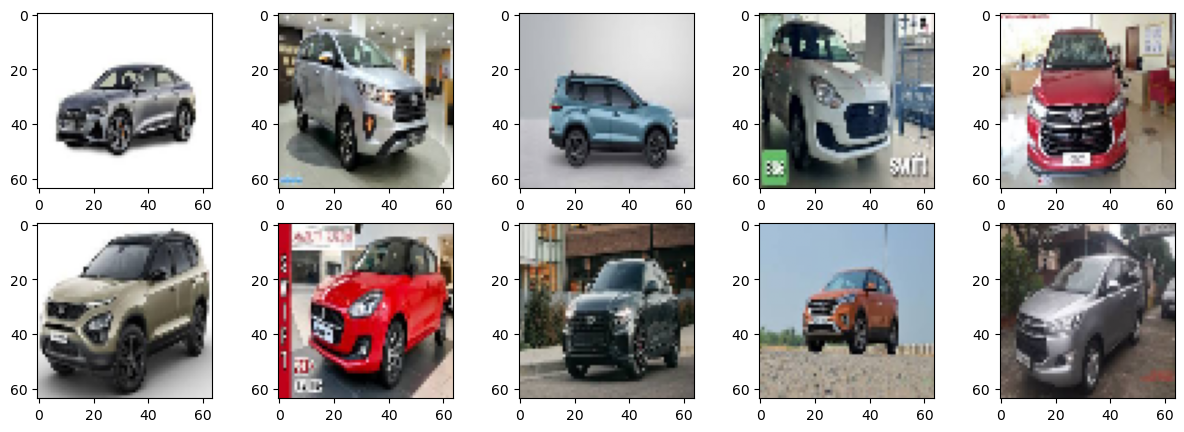

In [2]:
# dataset visualization
plt.figure(figsize=(15, 5))
for i, r_idx in enumerate(np.random.randint(0, images_np.shape[0], 10)):
    ax = plt.subplot(2,5,i+1)
    ax.imshow(images_np[r_idx])

In [3]:
# stratified 5-Fold Cross-Validation
from sklearn.model_selection import StratifiedKFold

n_splits = 5
shuffle_splitter = StratifiedKFold(n_splits=n_splits)

# Iterate over splits
for fold, (train_index, test_index) in enumerate(shuffle_splitter.split(images_np, labels_np)):
    X_train, X_test = images_np[train_index], images_np[test_index]
    y_train, y_test = labels_np[train_index], labels_np[test_index]
    print(f"Split {fold+1} - Train Shape: {X_train.shape}, Test Shape: {X_test.shape}")

Split 1 - Train Shape: (3332, 64, 64, 3), Test Shape: (833, 64, 64, 3)
Split 2 - Train Shape: (3332, 64, 64, 3), Test Shape: (833, 64, 64, 3)
Split 3 - Train Shape: (3332, 64, 64, 3), Test Shape: (833, 64, 64, 3)
Split 4 - Train Shape: (3332, 64, 64, 3), Test Shape: (833, 64, 64, 3)
Split 5 - Train Shape: (3332, 64, 64, 3), Test Shape: (833, 64, 64, 3)


### 2. Modeling
#### 2.1 Data Expansion (Augmentation)

In [4]:
from keras.utils import to_categorical

num_classes = len(set(y_train))
print("Number of classes:", num_classes)

y_train_ohe = to_categorical(y_train, num_classes=num_classes)

y_test_ohe = to_categorical(y_test, num_classes=num_classes)

print(f"Y train shape: {y_train_ohe.shape}, Y test shape: {y_test_ohe.shape}")

Number of classes: 7
Y train shape: (3332, 7), Y test shape: (833, 7)


The y_train and y_test have been one hot encoded to have 7 classes for multiclassification. 

In [5]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import plot_model, to_categorical
from keras.callbacks import EarlyStopping
from sklearn.metrics import f1_score


print(f"system keras Version: {keras.__version__}")

system keras Version: 3.2.1


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=5, # used, Int. Degree range for random rotations.
    width_shift_range=0.1, # used, Float (fraction of total width). Range for random horizontal shifts.
    height_shift_range=0.1, # used,  Float (fraction of total height). Range for random vertical shifts.
    shear_range=0.2, # Float. Shear Intensity (Shear angle in counter-clockwise direction as radians)
    zoom_range=0.1,
    channel_shift_range=0.,
    fill_mode='nearest',
    cval=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    rescale=None
)

datagen.fit(X_train)

The chosen data expansion techniques aptly simulate real-world variations in object orientation, position, perspective, and appearance, bolstering the dataset's resilience and its capacity for generalization. By introducing diverse transformations such as rotation, shifting, shearing, and flipping, the model becomes adept at recognizing objects across a spectrum of conditions. Moreover, the inclusion of a customized preprocessing function further diversifies the dataset by introducing variations in color, noise, and image structure, fostering the model's ability to discern essential features amidst variability.

### 2.2 CNN 

The two CNNs architectures we will utilize are AlexNet and Ensemble Nets. 

#### 2.2.1 AlexNet

In [7]:
# example training code
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import plot_model, to_categorical

alexnet = Sequential(name='alexnet')

alexnet.add(Conv2D(filters=32,
                   input_shape = (64,64,3),
                   kernel_size= (3,3),
                   padding='same',
                   activation='relu',
                   data_format='channels_last'))

alexnet.add(Conv2D(filters=64,
                    kernel_size=(3,3),
                    padding='same',
                    activation='relu'))
alexnet.add(MaxPooling2D(pool_size=(2,2), data_format='channels_last'))

alexnet.add(Conv2D(filters=128,
                    kernel_size=(5,5),
                    padding='same',
                    activation='relu'))
alexnet.add(MaxPooling2D(pool_size=(2,2), data_format='channels_last'))

alexnet.add(Dropout(0.25))
alexnet.add(Flatten())
alexnet.add(Dense(128, activation='relu'))
alexnet.add(Dropout(0.5))
alexnet.add(Dense(num_classes, activation='softmax'))

alexnet.compile(loss='categorical_crossentropy',
                   optimizer='rmsprop',
                   metrics=['F1Score'])

alexnet.summary()

c:\Users\seren\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "alexnet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,419,655 (16.86 MB)

 Trainable params: 4,419,655 (16.86 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
alexnet_list = []
for fold, (train_index, test_index) in enumerate(shuffle_splitter.split(images_np, labels_np)):
    X_train, X_test = images_np[train_index], images_np[test_index]
    y_train, y_test = labels_np[train_index], labels_np[test_index]
    
    alexnet_history = alexnet.fit(X_train, y_train_ohe, 
                           batch_size=512, 
                           epochs=10, 
                           shuffle=True, 
                           verbose=1,
                           validation_data=(X_test, y_test_ohe),
                           callbacks=[EarlyStopping(monitor='val_loss', patience=2)])
    
    # Append the history object to the list
    alexnet_list.append(alexnet_history)

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 39s 5s/step - F1Score: 0.1136 - loss: 4.5338 - val_F1Score: 0.0558 - val_loss: 1.8948
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 34s 5s/step - F1Score: 0.0863 - loss: 1.8727 - val_F1Score: 0.0558 - val_loss: 1.9267
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 35s 5s/step - F1Score: 0.0921 - loss: 1.8885 - val_F1Score: 0.0605 - val_loss: 1.8701
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 34s 5s/step - F1Score: 0.0905 - loss: 1.8659 - val_F1Score: 0.0558 - val_loss: 1.9644
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 32s 5s/step - F1Score: 0.0910 - loss: 1.8807 - val_F1Score: 0.0617 - val_loss: 1.8763
Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 32s 4s/step - F1Score: 0.1015 - loss: 1.8727 - val_F1Score: 0.1346 - val_loss: 1.8411
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 35s 5s/step - F1Score: 0.1356 - loss: 1.8570 - val_F1Score: 0.1165 - val_loss: 1.8375
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 37s 4s/step - F1Score: 0.1531 - loss: 1.8207 - val_F1Score: 0.2036 - val_loss: 1.7863
Epoch 4/10
7/7 ━━━━━━━━━

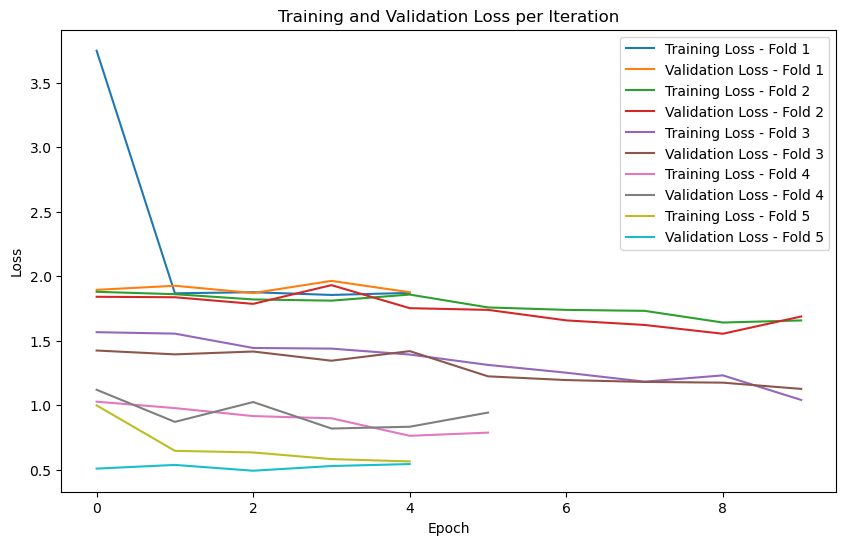

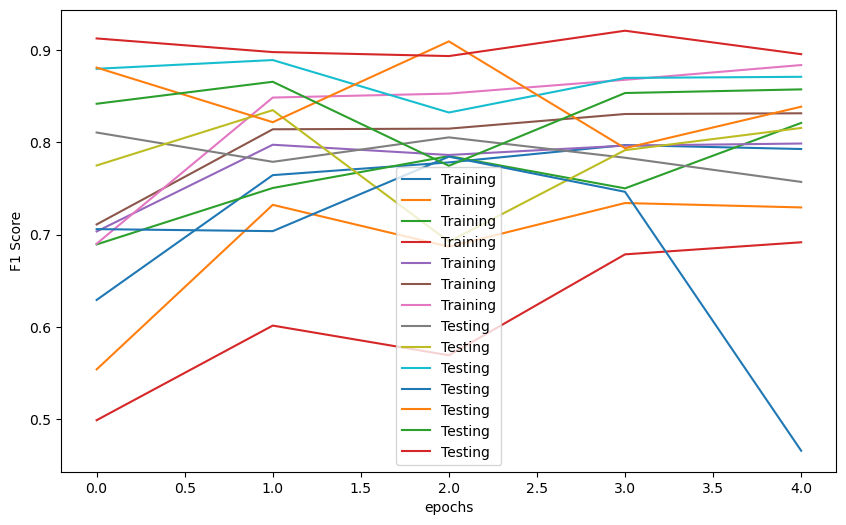

In [9]:
plt.figure(figsize=(10, 6))

for fold, history in enumerate(alexnet_list):
    plt.plot(history.history['loss'], label=f'Training Loss - Fold {fold+1}')
    plt.plot(history.history['val_loss'], label=f'Validation Loss - Fold {fold+1}')

plt.title('Training and Validation Loss per Iteration')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# plt.figure(figsize=(10, 6))
# plt.plot(alexnet_list[-1].history['f1_score'],label='Training')
# plt.plot(alexnet_list[-1].history['val_f1_score'],label='Testing')
# plt.ylabel('F1 Score')
# plt.xlabel('epochs')
# plt.legend()
# plt.show()

plt.figure(figsize=(10, 6))
plt.plot(alexnet_list[-1].history['F1Score'], label='Training')
plt.plot(alexnet_list[-1].history['val_F1Score'], label='Testing')
plt.ylabel('F1 Score')
plt.xlabel('epochs')
plt.legend()
plt.show()

#### 2.2.2 AlexNet with increased kernels and adam optimizer.

In [10]:
# example training code
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import plot_model, to_categorical

alexnet_1 = Sequential(name='alexnet_modified')

alexnet_1.add(Conv2D(filters=32,
                   input_shape = (64,64,3),
                   kernel_size= (5,5),
                   padding='same',
                   activation='relu',
                   data_format='channels_last'))

alexnet_1.add(Conv2D(filters=64,
                    kernel_size=(5,5),
                    padding='same',
                    activation='relu'))
alexnet_1.add(MaxPooling2D(pool_size=(2,2), data_format='channels_last'))

alexnet_1.add(Conv2D(filters=128,
                    kernel_size=(7,7),
                    padding='same',
                    activation='relu'))
alexnet_1.add(MaxPooling2D(pool_size=(2,2), data_format='channels_last'))

alexnet_1.add(Dropout(0.25))
alexnet_1.add(Flatten())
alexnet_1.add(Dense(128, activation='relu'))
alexnet_1.add(Dropout(0.5))
alexnet_1.add(Dense(num_classes, activation='softmax'))

alexnet_1.compile(loss='categorical_crossentropy',
                   optimizer='adam',
                   metrics=['F1Score'])

alexnet_1.summary()

c:\Users\seren\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "alexnet_modified"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,650,567 (17.74 MB)

 Trainable params: 4,650,567 (17.74 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
alexnet_mod_list = []
for fold, (train_index, test_index) in enumerate(shuffle_splitter.split(images_np, labels_np)):
    X_train, X_test = images_np[train_index], images_np[test_index]
    y_train, y_test = labels_np[train_index], labels_np[test_index]
    
    alexnet_mod_history = alexnet_1.fit(X_train, y_train_ohe, 
                           batch_size=512, 
                           epochs=10, 
                           shuffle=True, 
                           verbose=1,
                           validation_data=(X_test, y_test_ohe),
                           callbacks=[EarlyStopping(monitor='val_loss', patience=3)])
    
    # Append the history object to the list
    alexnet_mod_list.append(alexnet_mod_history)

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 77s 11s/step - F1Score: 0.1147 - loss: 2.1621 - val_F1Score: 0.0537 - val_loss: 1.9400
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 70s 10s/step - F1Score: 0.0741 - loss: 1.9185 - val_F1Score: 0.0558 - val_loss: 1.8711
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 68s 10s/step - F1Score: 0.0935 - loss: 1.8711 - val_F1Score: 0.0716 - val_loss: 1.8676
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 65s 9s/step - F1Score: 0.0924 - loss: 1.8601 - val_F1Score: 0.0603 - val_loss: 1.8747
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 61s 9s/step - F1Score: 0.0968 - loss: 1.8643 - val_F1Score: 0.0686 - val_loss: 1.8714
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 61s 9s/step - F1Score: 0.0960 - loss: 1.8535 - val_F1Score: 0.0724 - val_loss: 1.8752
Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 64s 9s/step - F1Score: 0.0881 - loss: 1.8925 - val_F1Score: 0.0869 - val_loss: 1.8581
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 64s 9s/step - F1Score: 0.1137 - loss: 1.8635 - val_F1Score: 0.1129 - val_loss: 1.8291
Epoch 3/10
7/7 ━━━━━━

KeyboardInterrupt: 

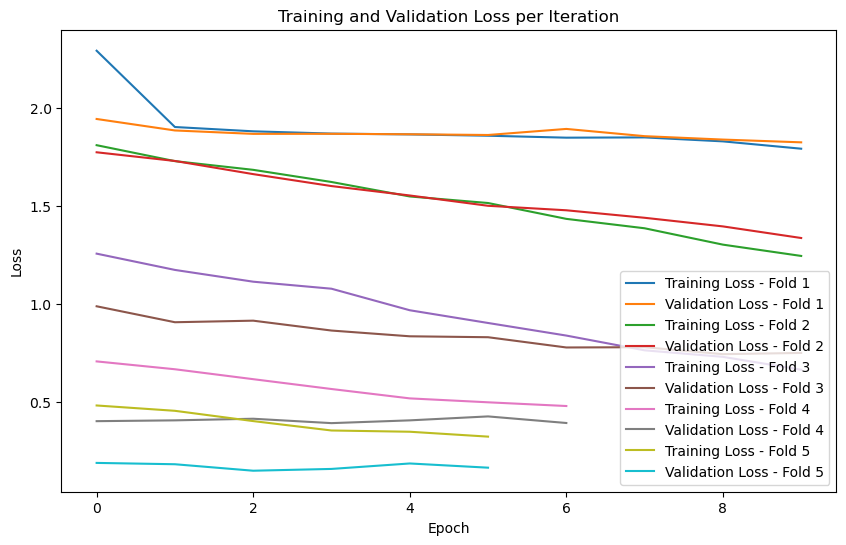

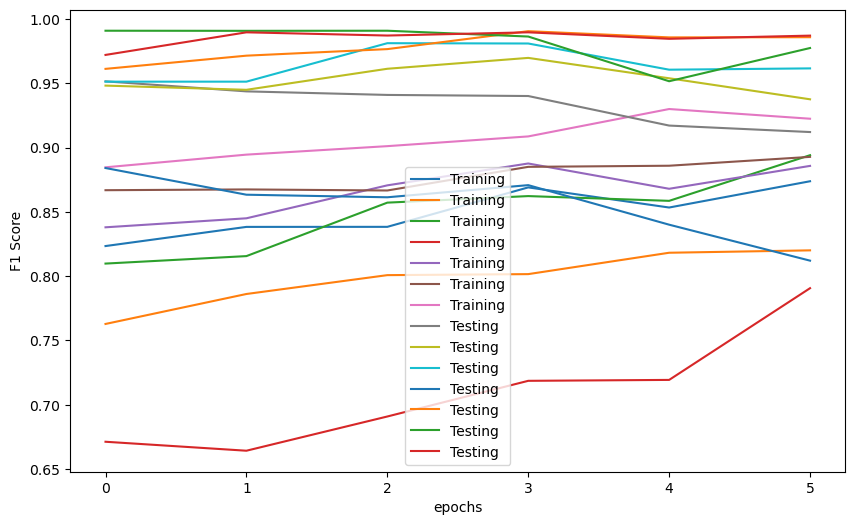

In [ ]:
plt.figure(figsize=(10, 6))

for fold, history in enumerate(alexnet_mod_list):
    plt.plot(history.history['loss'], label=f'Training Loss - Fold {fold+1}')
    plt.plot(history.history['val_loss'], label=f'Validation Loss - Fold {fold+1}')

plt.title('Training and Validation Loss per Iteration')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# plt.figure(figsize=(10, 6))
# plt.plot(alexnet_mod_list[-1].history['F1Sccore'],label='Training')
# plt.plot(alexnet_mod_list[-1].history['val_fscore'],label='Testing')
# plt.ylabel('F1 Score')
# plt.xlabel('epochs')
# plt.legend()
# plt.show()
plt.figure(figsize=(10, 6))
plt.plot(alexnet_list[-1].history['F1Score'], label='Training')
plt.plot(alexnet_list[-1].history['val_F1Score'], label='Testing')
plt.ylabel('F1 Score')
plt.xlabel('epochs')
plt.legend()
plt.show()

#### 2.2.3 Ensemble Net

In [ ]:
from tensorflow.keras.layers import Input, average, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

num_ensembles = 3
l2_lambda = 0.000001
img_wh = 64

input_holder = Input(shape=(img_wh, img_wh, 3))

# start with a conv layer
x = Conv2D(filters=32,
               input_shape = (img_wh,img_wh,3),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', data_format="channels_last")(input_holder)

x = Conv2D(filters=32,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu')(x)
input_conv = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

branches = []
for _ in range(num_ensembles):
    
    # start using NiN (MLPConv)
    x = Conv2D(filters=32,
                   input_shape = (img_wh,img_wh,3),
                   kernel_size=(3,3),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='linear', data_format="channels_last")(input_conv)

    x = Conv2D(filters=32,
                   kernel_size=(1,1),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='relu', data_format="channels_last")(x)
    
    x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)
    
    x = Conv2D(filters=64,
                   input_shape = (img_wh,img_wh,3),
                   kernel_size=(3,3),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='linear', data_format="channels_last")(x)

    x = Conv2D(filters=64,
                   kernel_size=(1,1),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='linear', data_format="channels_last")(x)
    
    x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

    # add one layer on flattened output
    x = Flatten()(x)
    x = Dropout(0.50)(x) # add some dropout for regularization after conv layers
    x = Dense(64, 
              activation='relu',
              kernel_initializer='he_uniform',
              kernel_regularizer=l2(l2_lambda)
            )(x)
    
    x = Dense(num_classes, 
              activation='relu',
              kernel_initializer='he_uniform',
              kernel_regularizer=l2(l2_lambda)
             )(x)
    
    # now add this branch onto the master list
    branches.append(x)

# that's it, we just need to average the results
x = concatenate(branches)

x = Dense(num_classes, 
          activation='softmax', 
          kernel_initializer='glorot_uniform',
          kernel_regularizer=l2(l2_lambda)
         )(x)

# here is the secret sauce for setting the network using the 
#   Functional API:
cnn_ens = Model(inputs=input_holder,outputs=x)

cnn_ens.compile(loss='categorical_crossentropy',
                   optimizer='rmsprop',
                   metrics=['F1Score'])

cnn_ens.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d_24 (Conv2D)          (None, 64, 64, 32)           896       ['input_1[0][0]']             
                                                                                                  
 conv2d_25 (Conv2D)          (None, 64, 64, 32)           9248      ['conv2d_24[0][0]']           
                                                                                                  
 max_pooling2d_16 (MaxPooli  (None, 32, 32, 32)           0         ['conv2d_25[0][0]']           
 ng2D)                                                                                        

In [ ]:
cnnens_list = []
for fold, (train_index, test_index) in enumerate(shuffle_splitter.split(images_np, labels_np)):
    X_train, X_test = images_np[train_index], images_np[test_index]
    y_train, y_test = labels_np[train_index], labels_np[test_index]
    
    cnnens_history = cnn_ens.fit(X_train, y_train_ohe, 
                           batch_size=512, 
                           epochs=10, 
                           shuffle=True, 
                           verbose=1,
                           validation_data=(X_test, y_test_ohe),
                           callbacks=[EarlyStopping(monitor='val_loss', patience=3)])
    
    # Append the history object to the list
    cnnens_list.append(cnnens_history)

Epoch 1/10
7/7 [==============================] - 11s 1s/step - loss: 4.0140 - f1_score: 0.1255 - val_loss: 1.9536 - val_f1_score: 0.0619
Epoch 2/10
7/7 [==============================] - 10s 1s/step - loss: 1.8979 - f1_score: 0.0789 - val_loss: 1.8868 - val_f1_score: 0.0560
Epoch 3/10
7/7 [==============================] - 10s 1s/step - loss: 1.8732 - f1_score: 0.0559 - val_loss: 1.8844 - val_f1_score: 0.0560
Epoch 4/10
7/7 [==============================] - 10s 1s/step - loss: 1.9021 - f1_score: 0.0569 - val_loss: 1.8931 - val_f1_score: 0.0560
Epoch 5/10
7/7 [==============================] - 11s 1s/step - loss: 1.8666 - f1_score: 0.0559 - val_loss: 1.9127 - val_f1_score: 0.0560
Epoch 6/10
7/7 [==============================] - 10s 1s/step - loss: 1.8570 - f1_score: 0.0569 - val_loss: 1.8995 - val_f1_score: 0.0560
Epoch 1/10
7/7 [==============================] - 10s 1s/step - loss: 1.8864 - f1_score: 0.0598 - val_loss: 1.8702 - val_f1_score: 0.0560
Epoch 2/10
7/7 [==================

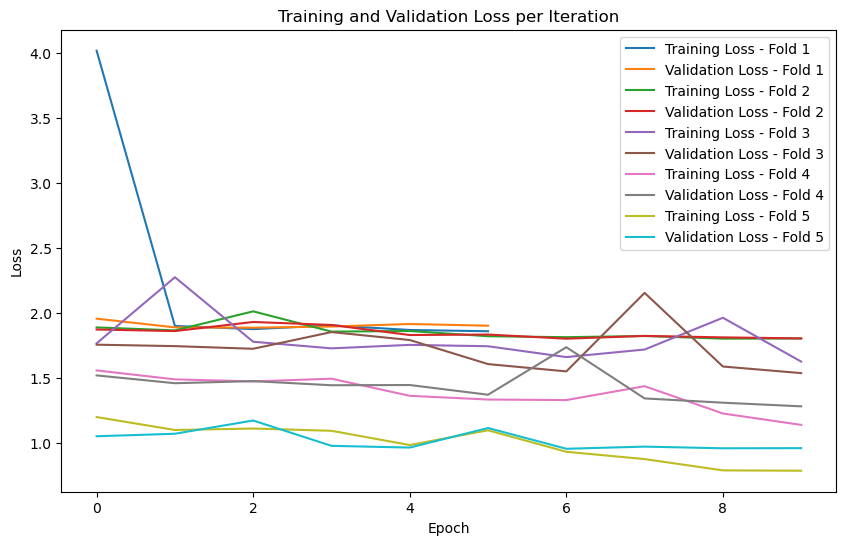

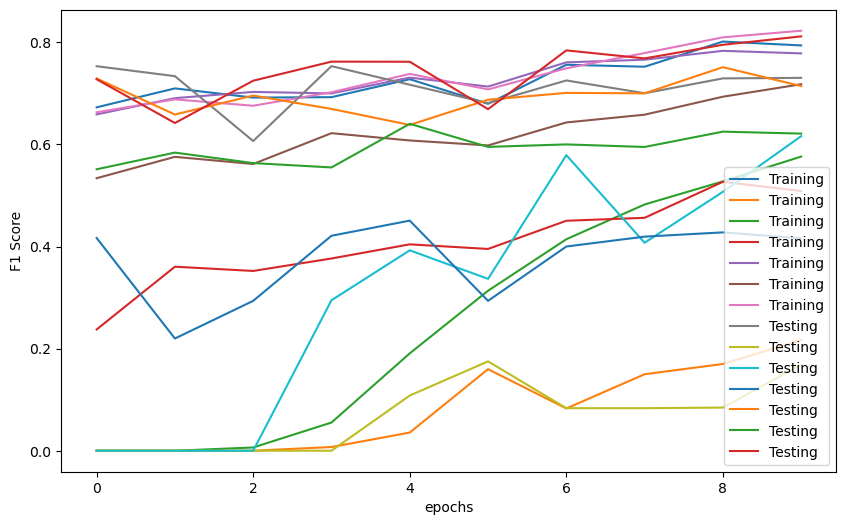

In [ ]:
plt.figure(figsize=(10, 6))

for fold, history in enumerate(cnnens_list):
    plt.plot(history.history['loss'], label=f'Training Loss - Fold {fold+1}')
    plt.plot(history.history['val_loss'], label=f'Validation Loss - Fold {fold+1}')

plt.title('Training and Validation Loss per Iteration')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(cnnens_list[-1].history['f1_score'],label='Training')
plt.plot(cnnens_list[-1].history['val_f1_score'],label='Testing')
plt.ylabel('F1 Score')
plt.xlabel('epochs')
plt.legend()
plt.show()

#### 2.2.4 Ensemble Net with increased filters

In [ ]:
num_ensembles = 3
l2_lambda = 0.000001
img_wh = 64

input_holder = Input(shape=(img_wh, img_wh, 3))

# start with a conv layer
x = Conv2D(filters=64,
               input_shape = (img_wh,img_wh,3),
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu', data_format="channels_last")(input_holder)

x = Conv2D(filters=64,
               kernel_size=(3,3),
               kernel_initializer='he_uniform', 
               kernel_regularizer=l2(l2_lambda),
               padding='same', 
               activation='relu')(x)
input_conv = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

branches = []
for _ in range(num_ensembles):
    
    # start using NiN (MLPConv)
    x = Conv2D(filters=64,
                   input_shape = (img_wh,img_wh,3),
                   kernel_size=(3,3),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='linear', data_format="channels_last")(input_conv)

    x = Conv2D(filters=64,
                   kernel_size=(1,1),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='relu', data_format="channels_last")(x)
    
    x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)
    
    x = Conv2D(filters=128,
                   input_shape = (img_wh,img_wh,3),
                   kernel_size=(3,3),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='linear', data_format="channels_last")(x)

    x = Conv2D(filters=128,
                   kernel_size=(1,1),
                   kernel_initializer='he_uniform', 
                   kernel_regularizer=l2(l2_lambda),
                   padding='same', 
                   activation='linear', data_format="channels_last")(x)
    
    x = MaxPooling2D(pool_size=(2, 2), data_format="channels_last")(x)

    # add one layer on flattened output
    x = Flatten()(x)
    x = Dropout(0.50)(x) # add some dropout for regularization after conv layers
    x = Dense(128, 
              activation='relu',
              kernel_initializer='he_uniform',
              kernel_regularizer=l2(l2_lambda)
            )(x)
    
    x = Dense(num_classes, 
              activation='relu',
              kernel_initializer='he_uniform',
              kernel_regularizer=l2(l2_lambda)
             )(x)
    
    # now add this branch onto the master list
    branches.append(x)

# that's it, we just need to average the results
x = concatenate(branches)

x = Dense(num_classes, 
          activation='softmax', 
          kernel_initializer='glorot_uniform',
          kernel_regularizer=l2(l2_lambda)
         )(x)

# here is the secret sauce for setting the network using the 
#   Functional API:
cnn_ens_1 = Model(inputs=input_holder,outputs=x)

cnn_ens_1.compile(loss='categorical_crossentropy',
                   optimizer='rmsprop',
                   metrics=['F1Score'])

cnn_ens_1.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d_38 (Conv2D)          (None, 64, 64, 64)           1792      ['input_2[0][0]']             
                                                                                                  
 conv2d_39 (Conv2D)          (None, 64, 64, 64)           36928     ['conv2d_38[0][0]']           
                                                                                                  
 max_pooling2d_23 (MaxPooli  (None, 32, 32, 64)           0         ['conv2d_39[0][0]']           
 ng2D)                                                                                      

In [ ]:
cnnens_mod_list = []
for fold, (train_index, test_index) in enumerate(shuffle_splitter.split(images_np, labels_np)):
    X_train, X_test = images_np[train_index], images_np[test_index]
    y_train, y_test = labels_np[train_index], labels_np[test_index]
    
    cnnens_mod_history = cnn_ens_1.fit(X_train, y_train_ohe, 
                           batch_size=512, 
                           epochs=10, 
                           shuffle=True, 
                           verbose=1,
                           validation_data=(X_test, y_test_ohe),
                           callbacks=[EarlyStopping(monitor='val_loss', patience=3)])
    
    # Append the history object to the list
    cnnens_mod_list.append(cnnens_mod_history)

Epoch 1/10
7/7 [==============================] - 28s 4s/step - loss: 48.4675 - f1_score: 0.1010 - val_loss: 2.5477 - val_f1_score: 0.0531
Epoch 2/10
7/7 [==============================] - 29s 4s/step - loss: 2.3540 - f1_score: 0.0920 - val_loss: 2.4027 - val_f1_score: 0.0605
Epoch 3/10
7/7 [==============================] - 29s 4s/step - loss: 2.0663 - f1_score: 0.1106 - val_loss: 1.9091 - val_f1_score: 0.0812
Epoch 4/10
7/7 [==============================] - 29s 4s/step - loss: 1.8816 - f1_score: 0.0942 - val_loss: 1.8846 - val_f1_score: 0.0655
Epoch 5/10
7/7 [==============================] - 28s 4s/step - loss: 1.9249 - f1_score: 0.1076 - val_loss: 1.8979 - val_f1_score: 0.0654
Epoch 6/10
7/7 [==============================] - 28s 4s/step - loss: 1.8692 - f1_score: 0.1018 - val_loss: 1.9017 - val_f1_score: 0.0664
Epoch 7/10
7/7 [==============================] - 28s 4s/step - loss: 1.8705 - f1_score: 0.1029 - val_loss: 1.8678 - val_f1_score: 0.0709
Epoch 8/10
7/7 [=================

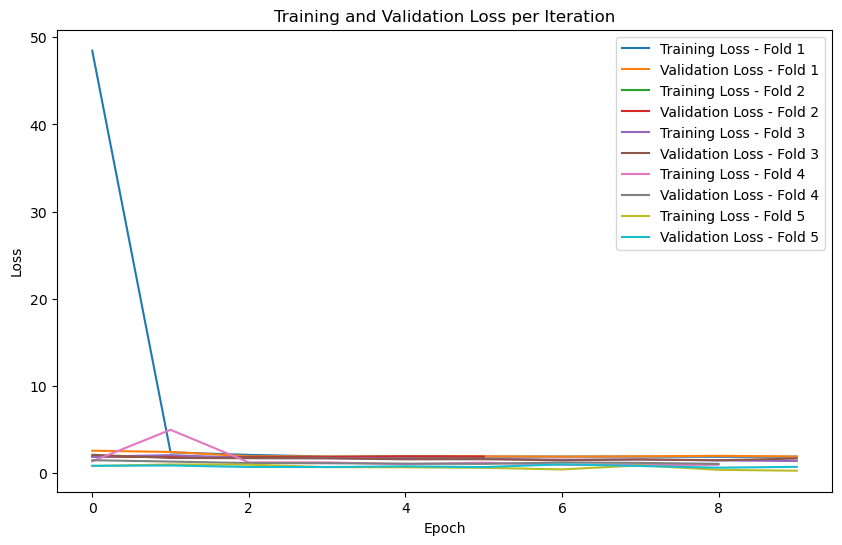

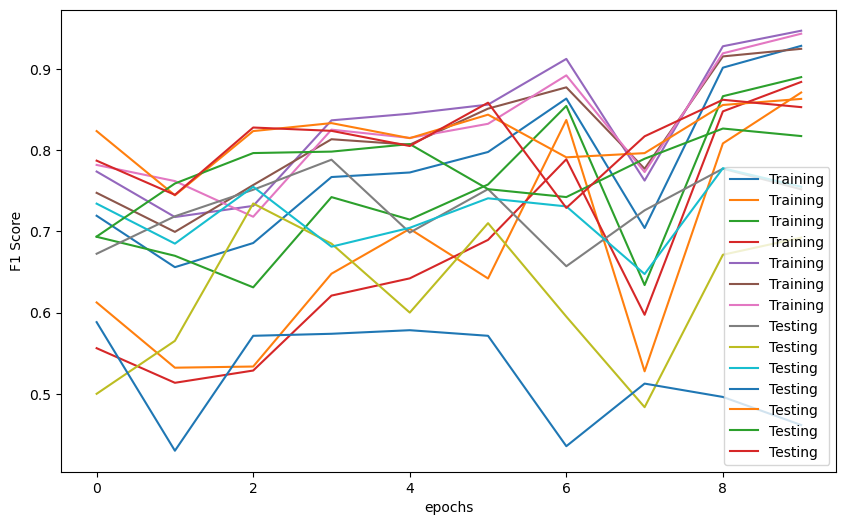

In [ ]:
plt.figure(figsize=(10, 6))

for fold, history in enumerate(cnnens_mod_list):
    plt.plot(history.history['loss'], label=f'Training Loss - Fold {fold+1}')
    plt.plot(history.history['val_loss'], label=f'Validation Loss - Fold {fold+1}')

plt.title('Training and Validation Loss per Iteration')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(cnnens_mod_list[-1].history['f1_score'],label='Training')
plt.plot(cnnens_mod_list[-1].history['val_f1_score'],label='Testing')
plt.ylabel('F1 Score')
plt.xlabel('epochs')
plt.legend()
plt.show()

#### 2.3 Visualize and Compare the Performance

##### 2.3.1 Visualize results of all the CNNs

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats


def extract_performance_metrics(histories):
    
    mean_f1_scores = np.mean([history.history['F1Score'][-1]
                             for history in histories])  # Assuming the last epoch's score
    mean_losses = np.mean([h.history['loss'][-1] for h in histories])
    return mean_f1_scores, mean_losses

alexnet_f1, alexnet_loss = extract_performance_metrics(alexnet_list)
alexnet_1_f1, alexnet_1_loss = extract_performance_metrics(alexnet_mod_list)
cnn_ens_f1, cnn_ens_loss = extract_performance_metrics(cnnens_list)
cnn_ens_1_f1, cnn_ens_1_loss = extract_performance_metrics(cnnens_mod_list)


def plot_metrics(models, metrics, title):
    plt.figure(figsize=(12, 8))
    for model_name, model_histories in models.items():
        for metric in metrics:
            means = [np.mean(history.history.get(metric, [0])) for history in model_histories]
            plt.plot(means, label=f'{model_name} - {metric}')

    plt.title(title)
    plt.ylabel('Metric Value')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    
# Define your models and their histories
model_histories = {
    'AlexNet': alexnet_list,
    'AlexNet Modified': alexnet_mod_list,
    'CNN Ensemble': cnnens_list,
    'CNN Ensemble Mod': cnnens_mod_list
}

# Plot F1 Scores and Losses
plot_metrics(model_histories, ['F1Score', 'loss'],
             ' F1 Score and Loss Comparison')

##### 2.3.2 Compare the performance using Confusion Matrix

In [ ]:
from sklearn import metrics as mt
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

def compare_models(alexnet, alexnet_1, cnn_ens, cnn_ens_1, X_test, y_test, labels='auto'):
    models = [alexnet, alexnet_1, cnn_ens, cnn_ens_1]
    model_names = ['Alexnet', 'Alexnet_1', 'CNN Ensemble', 'CNN Ensemble_1']
    results = {}
    plt.figure(figsize=(20,10))

    for idx, model in enumerate(models):
        if model is not None:
            yhat = np.argmax(model.predict(X_test), axis=1)
            f1_score = mt.f1_score(y_test, yhat, average='weighted')
            results[model_names[idx]] = f1_score
            
            plt.subplot(2, 2, idx + 1)
            cm = mt.confusion_matrix(y_test, yhat)
            cm_normalized = cm / np.sum(cm, axis=1, keepdims=True)
            sns.heatmap(cm_normalized, annot=True, fmt='.4f', xticklabels=labels, yticklabels=labels)
            plt.title(f'{model_names[idx]}: {f1_score:.4f}')

    plt.tight_layout()
    plt.show()
    return results


In [ ]:
compare_models(alexnet, alexnet_1, cnn_ens, cnn_ens_1, )

In [ ]:

# def get_best_model(alexnet, alexnet_1, cnn_ens, cnn_ens_1, X_test, y_tes, labels='auto'):
#     results = compare_models(alexnet, alexnet_1, cnn_ens,
#                              cnn_ens_1, X_test, y_test, labels)
#     best_model = max(results, key=results.get)
    
#     return best_model, results[best_model]

From above the result, the model 1- AlexNet had the best performance with highest F1 Score.
- In the next steps, we will use parameters from the cnn model with best performance to build a standard MLP then compare the cnn to MLP.

#### 2.4 Compare Convolutional Network to a Standard Multi-Layer Perceptron (MLP)
- Number of Units and Activation Functions: The model uses 128 units in the final dense layer before the output layer. We'll use a similar approach in the MLP.
- Dropout Rates: The model applies dropout rates of 0.25 and 0.5 at different stages. We'll align the MLP to use similar dropout configurations.
- Optimizer: Both models will use 'rmsprop', which is consistent with what set for AlexNet.

##### 2.4.1 Define and Train the MLP

In [12]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import numpy as np

def build_mlp(input_shape, num_classes):
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))
    
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(num_classes, activation='softmax'))
    return model

input_shape = (64, 64, 3)

# Initialize the MLP model
mlp_model = build_mlp(input_shape, num_classes)
mlp_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['F1Score'])

mlp_model.summary()

c:\Users\seren\anaconda3\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 12288)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     1,572,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,590,407 (6.07 MB)

 Trainable params: 1,590,407 (6.07 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Train the model using cross-validation
    
mlp_history_list = []
for fold, (train_index, test_index) in enumerate(shuffle_splitter.split(images_np, labels_np)):
    X_train, X_test = images_np[train_index], images_np[test_index]
    y_train, y_test = labels_np[train_index], labels_np[test_index]

    mlp_history = mlp_model.fit(X_train, y_train_ohe,
                                       batch_size=512,
                                       epochs=10,
                                       shuffle=True,
                                       verbose=1,
                                       validation_data=(X_test, y_test_ohe),
                                       callbacks=[EarlyStopping(monitor='val_loss', patience=3)])

    # Append the history object to the list
    mlp_history_list.append(mlp_history)
    

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - F1Score: 0.0875 - loss: 1.9298 - val_F1Score: 0.0564 - val_loss: 1.9256
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - F1Score: 0.0977 - loss: 1.9233 - val_F1Score: 0.0558 - val_loss: 1.9178
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - F1Score: 0.1094 - loss: 1.9243 - val_F1Score: 0.0553 - val_loss: 1.9141
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - F1Score: 0.0919 - loss: 1.9120 - val_F1Score: 0.0554 - val_loss: 1.9081
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - F1Score: 0.0951 - loss: 1.9080 - val_F1Score: 0.0558 - val_loss: 1.9023
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - F1Score: 0.0963 - loss: 1.8989 - val_F1Score: 0.0558 - val_loss: 1.8961
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - F1Score: 0.0999 - loss: 1.8906 - val_F1Score: 0.0553 - val_loss: 1.8907
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - F1Score: 0.0904 - loss: 1.8884 - val_F1Score: 0.0659 - val_loss: 1.8833
Epoch 9/10
7/7 ━

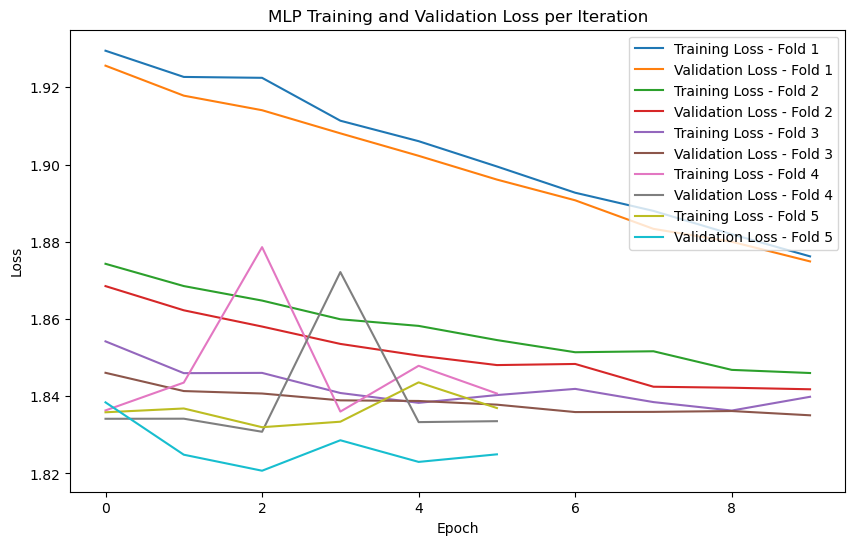

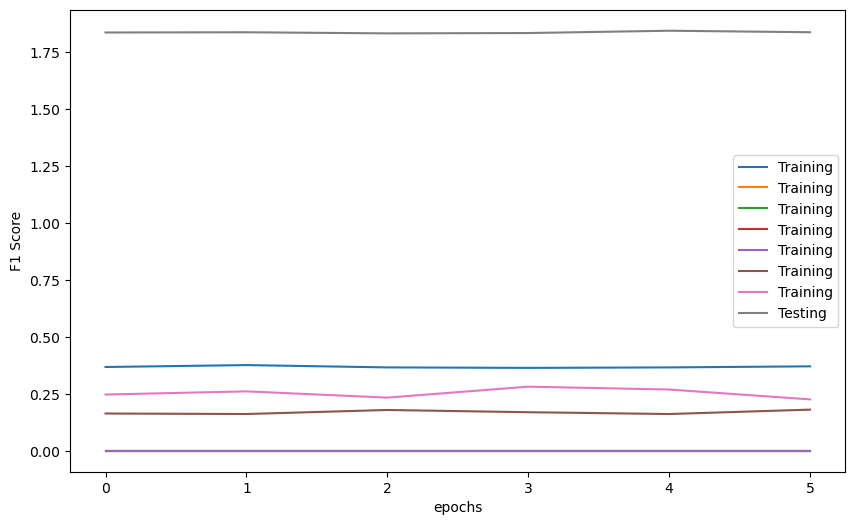

In [16]:
plt.figure(figsize=(10, 6))
for fold, history in enumerate(mlp_history_list):
    plt.plot(history.history['loss'], label=f'Training Loss - Fold {fold+1}')
    plt.plot(history.history['val_loss'], label=f'Validation Loss - Fold {fold+1}')

plt.title('MLP Training and Validation Loss per Iteration')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(mlp_history_list[-1].history['F1Score'], label='Training')
plt.plot(mlp_history_list[-1].history['loss'], label='Testing')
plt.ylabel('F1 Score')
plt.xlabel('epochs')
plt.legend()
plt.show()

##### 2.4.2 Compare the performances using the receiver operating characteristic and the area under the curve

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc, f1_score
from tensorflow.keras.utils import to_categorical


def plot_roc_curve(models, model_names, X_test, y_test, num_classes):
    plt.figure(figsize=(10, 8))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red'])

    # Check if y_test is one-hot encoded and convert if necessary
    if y_test.ndim > 1 and y_test.shape[1] > 1:
        y_test = np.argmax(y_test, axis=1)

    for model, color, model_name in zip(models, colors, model_names):
        if not hasattr(model, 'predict'):
            raise ValueError(
                f"The model {model_name} does not support predict method.")

        y_pred_prob = model.predict(X_test)
        y_pred = np.argmax(y_pred_prob, axis=1)
        y_test_binary = to_categorical(y_test, num_classes=num_classes)

        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        f1_scores = []

        f1 = f1_score(y_test, y_pred, average='weighted')
        f1_scores.append(f1)

        for i in range(num_classes):
            fpr[i], tpr[i], _ = roc_curve(
                y_test_binary[:, i], y_pred_prob[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        fpr["micro"], tpr["micro"], _ = roc_curve(
            y_test_binary.ravel(), y_pred_prob.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        plt.plot(fpr["micro"], tpr["micro"], color=color,
                 label=f'ROC curve of {model_name} (area = {roc_auc["micro"]:.4f})')

        avg_auc = np.mean([roc_auc[i] for i in range(num_classes)])
        avg_f1 = np.mean(f1_scores)
        print(
            f'{model_name} - Average AUC Score: {avg_auc:.4f}, Average F1 Score: {avg_f1:.4f}')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Micro-average ROC curve')
    plt.legend(loc="lower right")
    plt.show()

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step
AlexNet - Average AUC Score: 0.9764, Average F1 Score: 0.8010
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
MLP - Average AUC Score: 0.5194, Average F1 Score: 0.1295


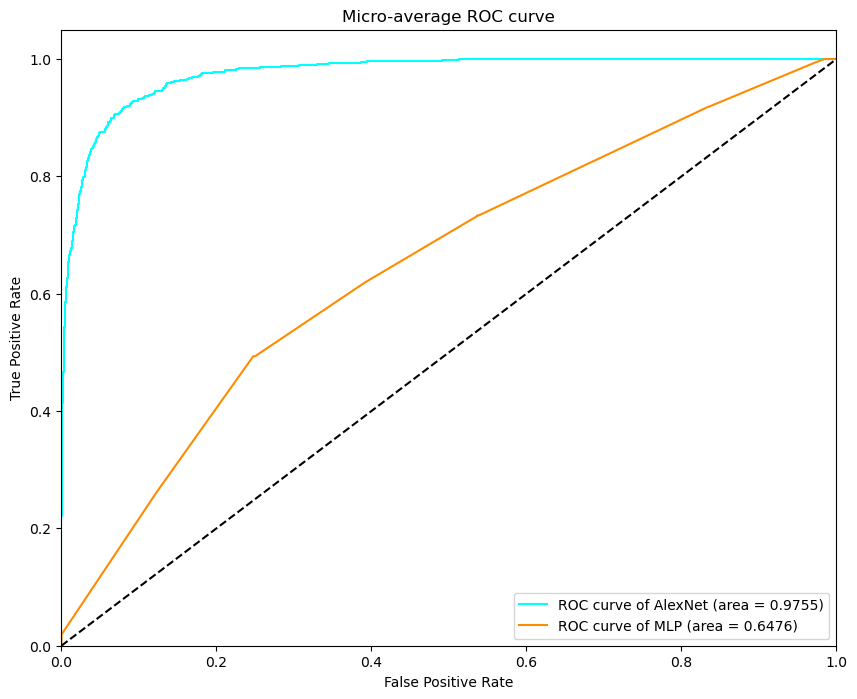

In [24]:
models = [alexnet, mlp_model]
model_names = ['AlexNet', 'MLP']
plot_roc_curve(models, model_names, X_test, y_test, num_classes)

### 3. Exceptional Work
#### 3.1 Transfer Learning
 - Use VGG16 pre-trained weights

In [26]:
from keras.applications import VGG16
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import RMSprop

# Load the VGG16 network, pre-trained on the ImageNet dataset, without the final classifier layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False
    
# Create a new model on top
x = base_model.output
x = Flatten()(x)
x=  Dense(128, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(num_classes, activation='softmax')(x)

# This is the new model to train
vgg16_model = Model(inputs=base_model.input, outputs=x)

# Compile the model
vgg16_model.compile(optimizer=RMSprop(learning_rate=0.001), loss='categorical_crossentropy', metrics=['F1Score'])

vgg16_model.summary()


Model: "functional_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 64, 64, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 7)              │           90

 Total params: 14,994,375 (57.20 MB)

 Trainable params: 279,687 (1.07 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [27]:
# Train the model using cross-validation

y_train_ohe = to_categorical(y_train, num_classes=num_classes)
y_test_ohe = to_categorical(y_test, num_classes=num_classes)


vgg16_history_list = []
for fold, (train_index, test_index) in enumerate(shuffle_splitter.split(images_np, labels_np)):
    X_train, X_test = images_np[train_index], images_np[test_index]
    y_train, y_test = labels_np[train_index], labels_np[test_index]

    vgg16_model_history = vgg16_model.fit(X_train, y_train_ohe,
                                epochs=10,
                                batch_size=512,
                                shuffle=True,
                                verbose=1,
                                validation_data=(X_test, y_test_ohe),
                                callbacks=[EarlyStopping(monitor='val_loss', patience=3)])
    
    vgg16_history_list.append(vgg16_model_history)


Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 48s 7s/step - F1Score: 0.1421 - loss: 2.0138 - val_F1Score: 0.1055 - val_loss: 1.8903
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 43s 6s/step - F1Score: 0.1322 - loss: 1.8331 - val_F1Score: 0.1032 - val_loss: 1.9014
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 44s 6s/step - F1Score: 0.1626 - loss: 1.8154 - val_F1Score: 0.1164 - val_loss: 1.9134
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 47s 7s/step - F1Score: 0.1936 - loss: 1.7725 - val_F1Score: 0.1227 - val_loss: 1.9092
Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 49s 7s/step - F1Score: 0.1422 - loss: 1.8852 - val_F1Score: 0.1841 - val_loss: 1.7190
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 49s 7s/step - F1Score: 0.1946 - loss: 1.7538 - val_F1Score: 0.2207 - val_loss: 1.6771
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 48s 7s/step - F1Score: 0.2308 - loss: 1.6857 - val_F1Score: 0.2798 - val_loss: 1.6161
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 51s 7s/step - F1Score: 0.2881 - loss: 1.6380 - val_F1Score: 0.3337 - val_loss: 1.5400
Epoch 5/10
7/7 ━━━━━━━━━

#### 3.2 Compare the performance

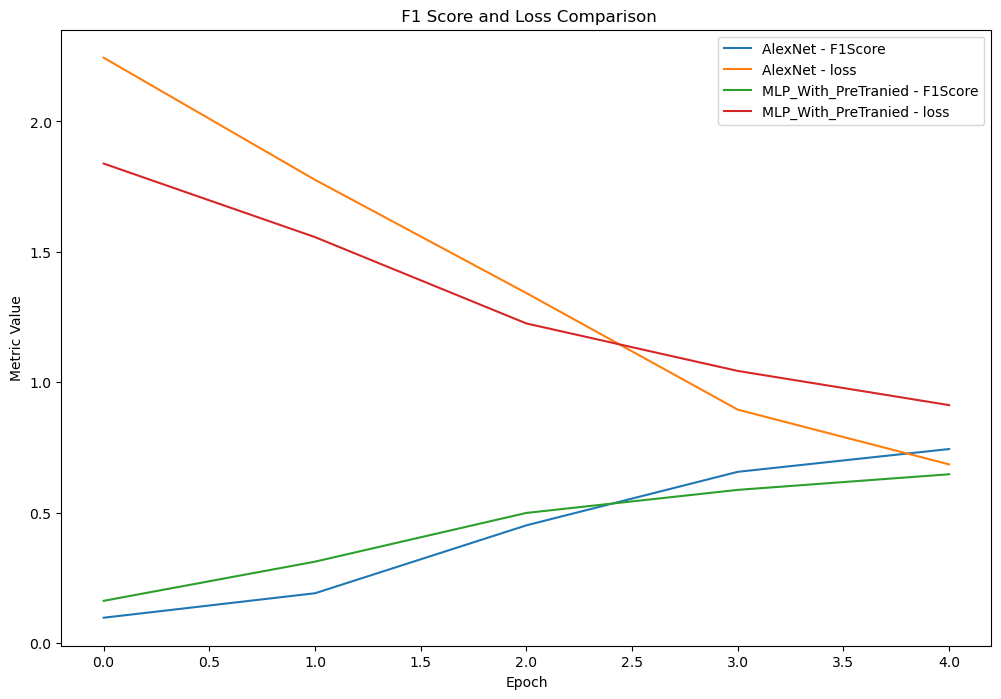

In [31]:
def extract_performance_metrics(histories):
    mean_f1_scores = np.mean([history.history['F1Score'][-1]
                             for history in histories])  # Assuming the last epoch's score
    mean_losses = np.mean([h.history['loss'][-1] for h in histories])
    return mean_f1_scores, mean_losses

vgg16_model_f1, vgg16_model_loss = extract_performance_metrics(vgg16_history_list)
best_cnn_f1, best_cnn_loss = extract_performance_metrics(alexnet_list)


def plot_metrics(models, metrics, title):
    plt.figure(figsize=(12, 8))
    for model_name, model_histories in models.items():
        for metric in metrics:
            means = [np.mean(history.history.get(metric, [0]))
                     for history in model_histories]
            plt.plot(means, label=f'{model_name} - {metric}')

    plt.title(title)
    plt.ylabel('Metric Value')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()


# Define your models and their histories
model_histories = {
    'AlexNet': alexnet_list,
    'MLP_With_PreTranied': vgg16_history_list
}

# Plot F1 Scores and Losses
plot_metrics(model_histories, ['F1Score', 'loss'],
             ' F1 Score and Loss Comparison')

Call plot_roc_curve() to compare the performance models

27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step
AlexNet - Average AUC Score: 0.9764, Average F1 Score: 0.8010
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 356ms/step
MLP_With_PreTranied - Average AUC Score: 0.9530, Average F1 Score: 0.7026


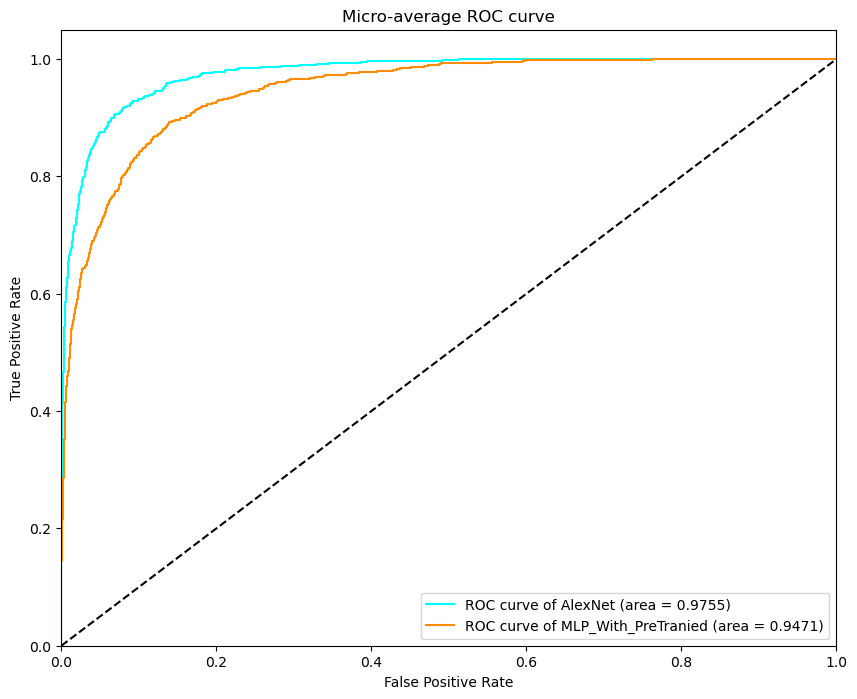

In [30]:
models = [alexnet, vgg16_model]
model_names = ['AlexNet', 'MLP_With_PreTranied']
plot_roc_curve(models, model_names, X_test, y_test, num_classes)

VGG16 is well-regarded for its ability to learn robust features due to its deep architecture and the large variety of images in the ImageNet dataset it was trained on. It's expected to perform well due to these pre-trained features.  
- Effectiveness: The pre-trained VGG16 model is likely to perform the best due to its depth and pre-learned features on a comprehensive dataset like ImageNet.
- Training Efficiency: VGG16 will be slower to train despite freezing the base layers because of its depth. Ensemble models might take longer due to the multiple branches being trained.

However, Our model combining pre-trained models like AlexNet with additional pre-trained layers or features is showing a lower ROC Value as well as lower F1 Score.


References:

- Kaggle. Car Images Dataset.https://www.kaggle.com/datasets/kshitij192/cars-image-datasetresource=download (Accessed 2-14-2024)


- Michael Abebe Berwo, et. al. "Deep Learning Techniques for Vehicle Detection and Classification from Images/Videos: A Survey" Sensors 2023, 23(10), 4832; https://doi.org/10.3390/s23104832


- Sumeyra Tas, et. al. "Deep Learning-Based Vehicle Classification for Low Quality Images" Sensors 2022, 22(13), 4740; https://doi.org/10.3390/s22134740